In [ ]:
import platform
import os

print("OS:", platform.system())
print("OS Version:", platform.version())
print("OS Release:", platform.release())
print("Python Version:", platform.python_version())
print("Processor:", platform.processor())
print("Machine:", platform.machine())
!nvidia-smi

OS: Linux
OS Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
OS Release: 6.1.85+
Python Version: 3.10.12
Processor: x86_64
Machine: x86_64
Wed Dec 11 12:34:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from albumentations import *
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import multiply



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Paths
metadata_path = '/content/drive/MyDrive/Project Data/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx'
image_dir = '/content/drive/MyDrive/Project Data/midasmultimodalimagedatasetforaibasedskincancer'

# Read patient metdata
metadata = pd.read_excel(metadata_path)

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3416 non-null   int64  
 1   midas_record_id        3416 non-null   int64  
 2   midas_file_name        3416 non-null   object 
 3   midas_iscontrol        3416 non-null   object 
 4   midas_distance         3416 non-null   object 
 5   midas_location         3416 non-null   object 
 6   midas_path             2919 non-null   object 
 7   midas_pathreport       2957 non-null   object 
 8   midas_gender           3416 non-null   object 
 9   midas_age              3416 non-null   int64  
 10  midas_fitzpatrick      3380 non-null   object 
 11  midas_melanoma         3386 non-null   object 
 12  midas_ethnicity        3416 non-null   object 
 13  midas_race             3416 non-null   object 
 14  clinical_impression_1  3360 non-null   object 
 15  clin

In [ ]:
metadata.head()

,Unnamed: 0,midas_record_id,midas_file_name,midas_iscontrol,midas_distance,midas_location,midas_path,midas_pathreport,midas_gender,midas_age,midas_fitzpatrick,midas_melanoma,midas_ethnicity,midas_race,clinical_impression_1,clinical_impression_2,clinical_impression_3,length_(mm),width_(mm)
0,0,1,s-prd-398966407.jpg,no,1ft,chest,malignant- sccis,"focal squamous cell carcinoma, in situ, aris...",female,80,"ii fair skin, blue eyes",no,no,white,7-malignant-bcc,6-benign-other,1-benign-melanocytic nevus,8.0,5.0
1,1,1,s-prd-398966642.jpg,no,6in,chest,malignant- sccis,"focal squamous cell carcinoma, in situ, aris...",female,80,"ii fair skin, blue eyes",no,no,white,7-malignant-bcc,6-benign-other,1-benign-melanocytic nevus,8.0,5.0
2,2,1,s-prd-398966845.jpg,no,dscope,chest,malignant- sccis,"focal squamous cell carcinoma, in situ, aris...",female,80,"ii fair skin, blue eyes",no,no,white,7-malignant-bcc,6-benign-other,1-benign-melanocytic nevus,8.0,5.0
3,3,1,s-prd-398967381.jpg,no,1ft,l lower back,benign-melanocytic nevus,"intradermal melanocytic nevus, transected at t...",female,80,"ii fair skin, blue eyes",no,no,white,1-benign-melanocytic nevus,6-benign-other,6-benign-other,6.0,5.0
4,4,1,s-prd-398967587.jpg,no,dscope,l lower back,benign-melanocytic nevus,"intradermal melanocytic nevus, transected at t...",female,80,"ii fair skin, blue eyes",no,no,white,1-benign-melanocytic nevus,6-benign-other,6-benign-other,6.0,5.0


In [ ]:
metadata.midas_melanoma.value_counts() ## this shows there is class imbalance which needs to be addressed

,count
midas_melanoma,
no,2719
yes,667


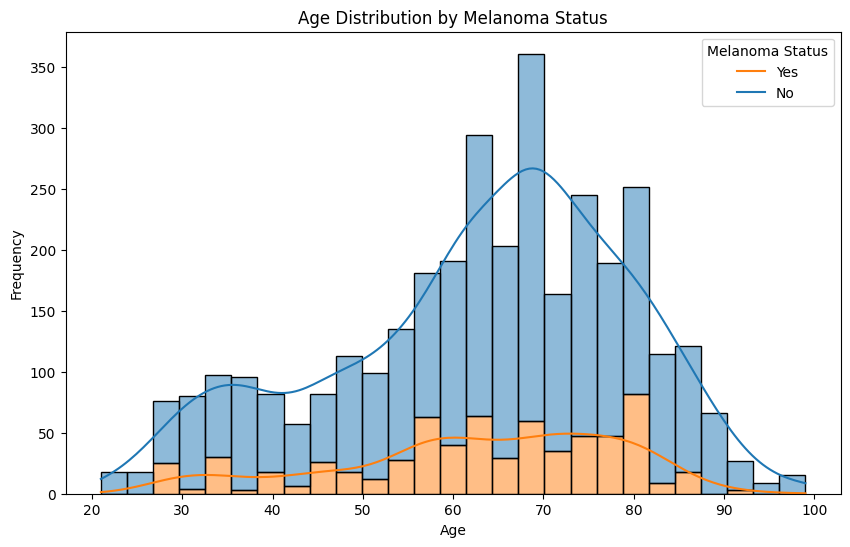

In [ ]:
## EDA and Visualisations

## Age distribution with melanoma status


plt.figure(figsize=(10, 6))
sns.histplot(data=metadata, x='midas_age', hue='midas_melanoma', kde=True, multiple='stack')
plt.title('Age Distribution by Melanoma Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title='Melanoma Status', labels=['Yes', 'No'])
plt.show()


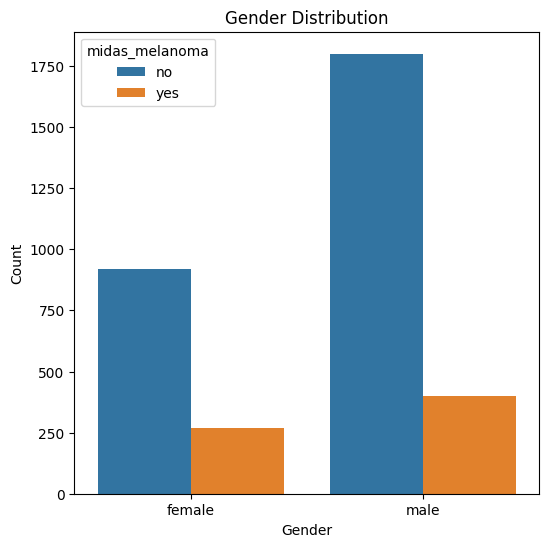

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=metadata, x='midas_gender',hue='midas_melanoma')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

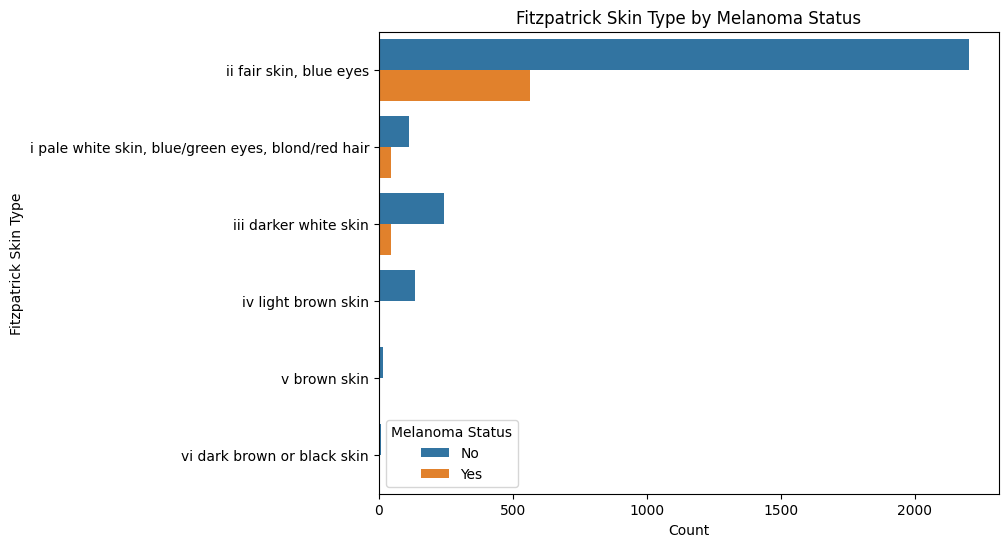

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=metadata, y='midas_fitzpatrick', hue='midas_melanoma')
plt.title('Fitzpatrick Skin Type by Melanoma Status')
plt.xlabel('Count')
plt.ylabel('Fitzpatrick Skin Type')
plt.legend(title='Melanoma Status', labels=['No', 'Yes'])
plt.show()


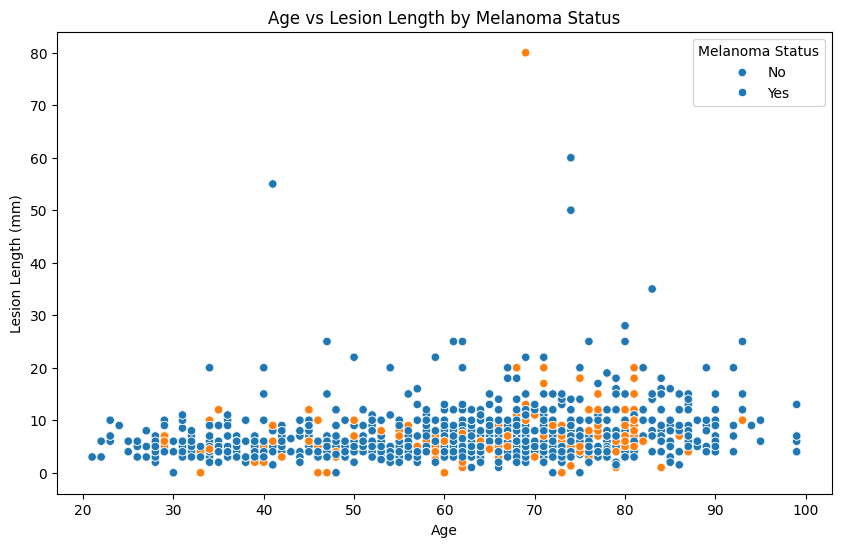

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=metadata, x='midas_age', y='length_(mm)', hue='midas_melanoma')
plt.title('Age vs Lesion Length by Melanoma Status')
plt.xlabel('Age')
plt.ylabel('Lesion Length (mm)')
plt.legend(title='Melanoma Status', labels=['No', 'Yes'])
plt.show()


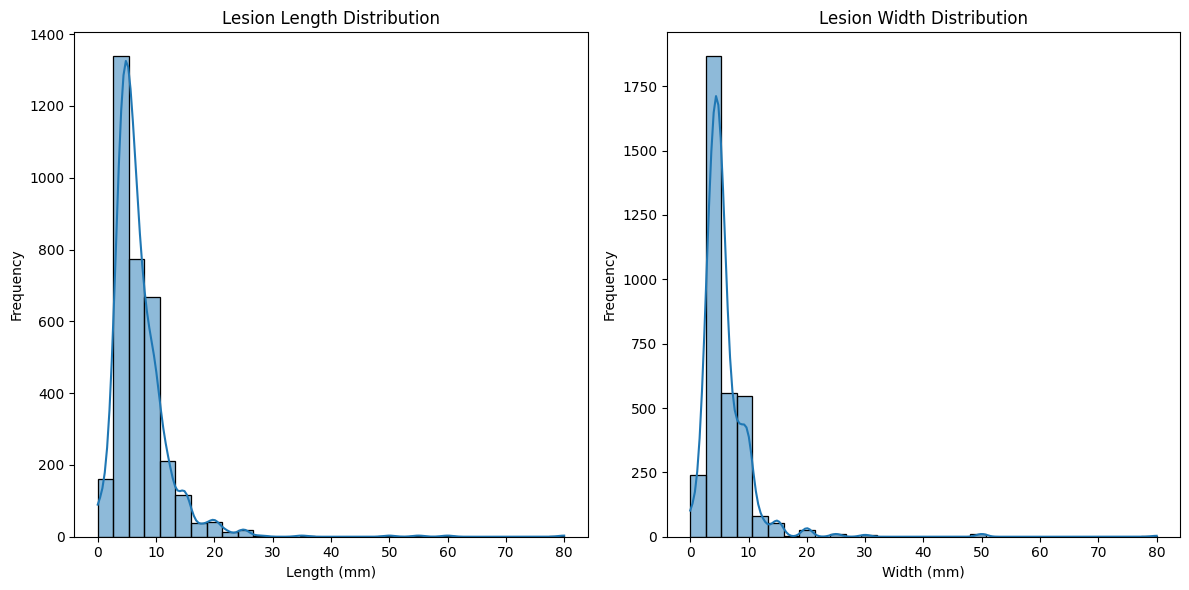

In [ ]:
plt.figure(figsize=(12, 6))

# Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(metadata['length_(mm)'], kde=True, bins=30)
plt.title('Lesion Length Distribution')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')

# Width Distribution
plt.subplot(1, 2, 2)
sns.histplot(metadata['width_(mm)'], kde=True, bins=30)
plt.title('Lesion Width Distribution')
plt.xlabel('Width (mm)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
metadata.isna().sum()

,0
Unnamed: 0,0
midas_record_id,0
midas_file_name,0
midas_iscontrol,0
midas_distance,0
midas_location,0
midas_path,497
midas_pathreport,459
midas_gender,0
midas_age,0


In [ ]:
## Removing columns which are unnecessary for model training
metadata = metadata.drop(columns=['Unnamed: 0','midas_record_id','midas_path', 'midas_pathreport'])



In [ ]:
## Dropping rows were target variable melanoma is missing
metadata = metadata.dropna(subset=['midas_melanoma'])


In [ ]:
# Handling  missing values
categorical_columns = ['midas_iscontrol', 'midas_location', 'midas_gender', 'midas_fitzpatrick',
                       'midas_ethnicity', 'midas_race','clinical_impression_1','clinical_impression_2','clinical_impression_3']
numerical_columns = ['midas_age', 'length_(mm)', 'width_(mm)']

metadata[categorical_columns] = metadata[categorical_columns].fillna('unknown')

metadata[numerical_columns] = metadata[numerical_columns].fillna(metadata[numerical_columns].median())

In [ ]:
## Top Feature selection using Random forest classifier

## Here we created a copy of metadata so that the main metdata dataframe is not affected by any changes made

features = metadata.copy()
metadata['midas_melanoma'] = metadata['midas_melanoma'].map({'yes': 1, 'no': 0})
features = pd.get_dummies(metadata, columns=[col for col in categorical_columns if col in metadata.columns], drop_first=True)




In [ ]:

X = features.drop(columns=['midas_melanoma','midas_distance','midas_file_name'])
y = features['midas_melanoma']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

model = RandomForestClassifier(random_state=42)
model.fit(X, y)


feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)


print("Top Features ")
print(top_features)


Top Features 
                                         Feature  Importance
0                                      midas_age    0.102852
2                                     width_(mm)    0.077259
1                                    length_(mm)    0.076017
499                            midas_gender_male    0.020078
542  clinical_impression_3_11-malignant-melanoma    0.016871
528  clinical_impression_2_11-malignant-melanoma    0.014569
514  clinical_impression_1_11-malignant-melanoma    0.013095
230                midas_location_left upper arm    0.012144
553                clinical_impression_3_unknown    0.012038
3                            midas_iscontrol_yes    0.011588


In [ ]:

# Selecting Columns based on their usage and information they provide
metadata = metadata[['midas_file_name', 'midas_iscontrol', 'midas_location', 'midas_gender',
                     'midas_age', 'midas_fitzpatrick', 'midas_melanoma', 'midas_ethnicity',
                     'midas_race', 'length_(mm)', 'width_(mm)','clinical_impression_1','clinical_impression_2','clinical_impression_3']]



<Axes: xlabel='midas_melanoma', ylabel='count'>

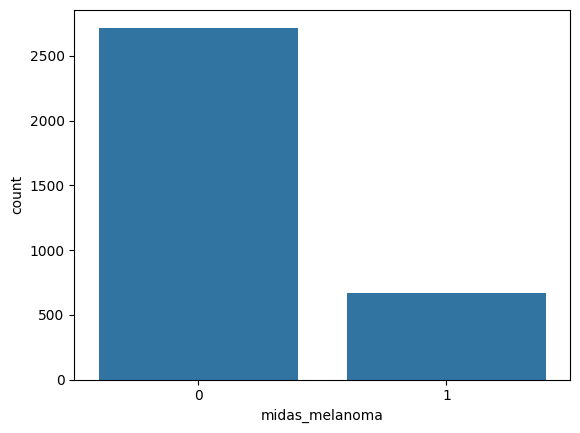

In [ ]:
sns.countplot(data=metadata,x='midas_melanoma')

In [ ]:
# Separate features and target
X = metadata.drop(columns=['midas_melanoma'])
y = metadata['midas_melanoma']

In [ ]:

# Encode categorical columns
label_encoders = {}
for col in categorical_columns + ['midas_melanoma']:
    le = LabelEncoder()
    metadata.loc[:, col] = le.fit_transform(metadata[col])
    label_encoders[col] = le

# Normalize numerical columns
scaler = StandardScaler()
metadata[numerical_columns] = scaler.fit_transform(metadata[numerical_columns])



In [ ]:

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))


In [ ]:
# Check if the corresponding image has entry in the metadata_filename column and only select the same
available_files = set(os.listdir(image_dir))
metadata = metadata[metadata['midas_file_name'].isin(available_files)]



In [ ]:
import cv2
# Reszing and ROI Detection with CLAHE
def apply_clahe(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img_gray)

def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot read {image_path}")
        return np.zeros((128, 128, 3))

    clahe_img = apply_clahe(img)
    clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
    resized_img = cv2.resize(clahe_img, (128, 128)) / 255.0
    return resized_img

In [ ]:
# Process Images
image_data = []
for _, row in metadata.iterrows():
    image_path = os.path.join(image_dir, row['midas_file_name'])
    image_data.append(process_image(image_path))
X_images = np.array(image_data)

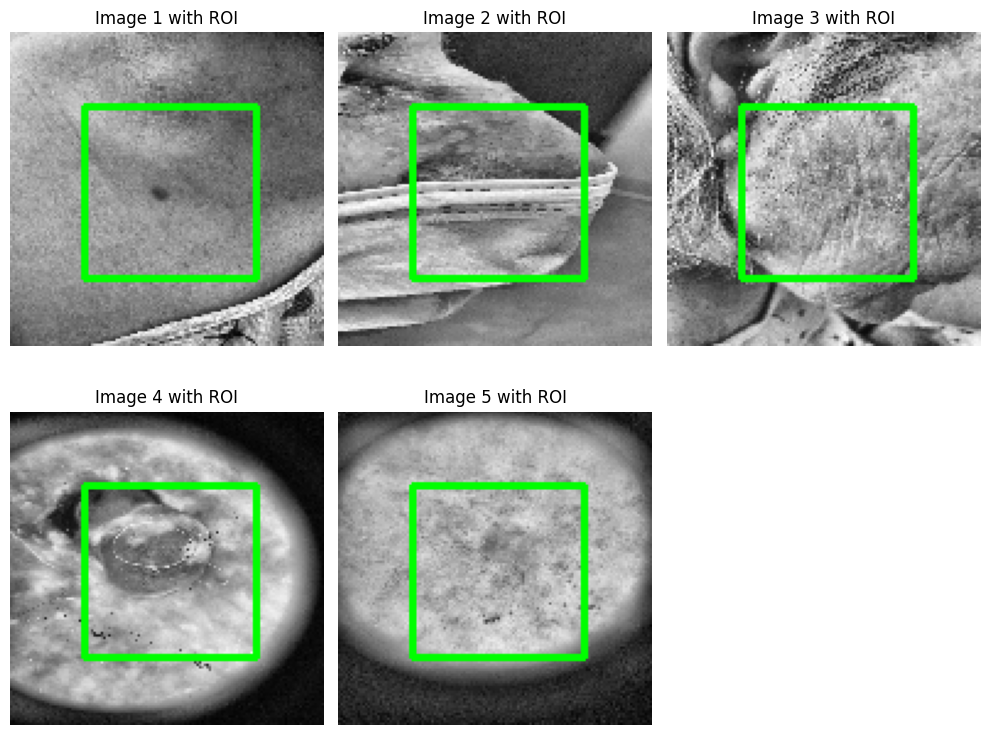

In [7]:
## To visualise how image looks after ROI
def process_and_draw_roi(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot read {image_path}")
        return None

    clahe_img = apply_clahe(img)
    clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)


    resized_img = cv2.resize(clahe_img, (128, 128))

    roi_top_left = (30, 30)
    roi_bottom_right = (100, 100)

    cv2.rectangle(resized_img, roi_top_left, roi_bottom_right, (0, 255, 0), 2)  # Green color

    return resized_img

image_files = os.listdir(image_dir)[:5]


plt.figure(figsize=(10, 8))


for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)

    processed_img = process_and_draw_roi(image_path)
    if processed_img is not None:
        plt.subplot(2, 3, i+1)
        plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i+1} with ROI")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

X_tabular = metadata.drop(columns=['midas_file_name', 'midas_melanoma'])
y = metadata['midas_melanoma']

In [ ]:
# Train-Test Split
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
## effecientnet model for image

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

image_input = Input(shape=(128, 128, 3), name="image_input")
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=image_input)


for layer in base_model.layers[:-20]:
    layer.trainable = False

# Image branch
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
image_features = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Tabular model branch
tabular_input_shape = X_train_tab.shape[1]
tabular_input = Input(shape=(tabular_input_shape,), name="tabular_input")
y = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(tabular_input)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(y)
y = BatchNormalization()(y)
metadata_features = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(y)


In [ ]:
## Multimodal model

combined = concatenate([image_features, metadata_features], name="combined_features")
z = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid', name="output")(z)


model_efficientnet = Model(inputs=[image_input, tabular_input], outputs=output, name="Multimodal_Model_EfficientNet")

model_efficientnet.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)
class_weights = {int(unique_classes[i]): class_weights[i] for i in range(len(unique_classes))}
print("Computed class weights:", class_weights)



y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

Computed class weights: {0: 0.6270080321285141, 1: 2.4683794466403164}


In [ ]:
#  Multimodal effecientnet

history = model_efficientnet.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights
)



Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 516ms/step - accuracy: 0.4654 - loss: 6.2521 - val_accuracy: 0.4608 - val_loss: 5.7043 - learning_rate: 3.0000e-04
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.4918 - loss: 5.7201 - val_accuracy: 0.2656 - val_loss: 5.3984 - learning_rate: 3.0000e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5217 - loss: 5.2772 - val_accuracy: 0.2096 - val_loss: 5.1073 - learning_rate: 3.0000e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5089 - loss: 4.9232 - val_accuracy: 0.2064 - val_loss: 4.7651 - learning_rate: 3.0000e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5589 - loss: 4.5745 - val_accuracy: 0.3024 - val_loss: 4.4585 - learning_rate: 3.0000e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5297 - loss: 4.2798 - val_accuracy: 0.4224 - val_loss: 4.1194 - learning_rate: 3.0000e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.51

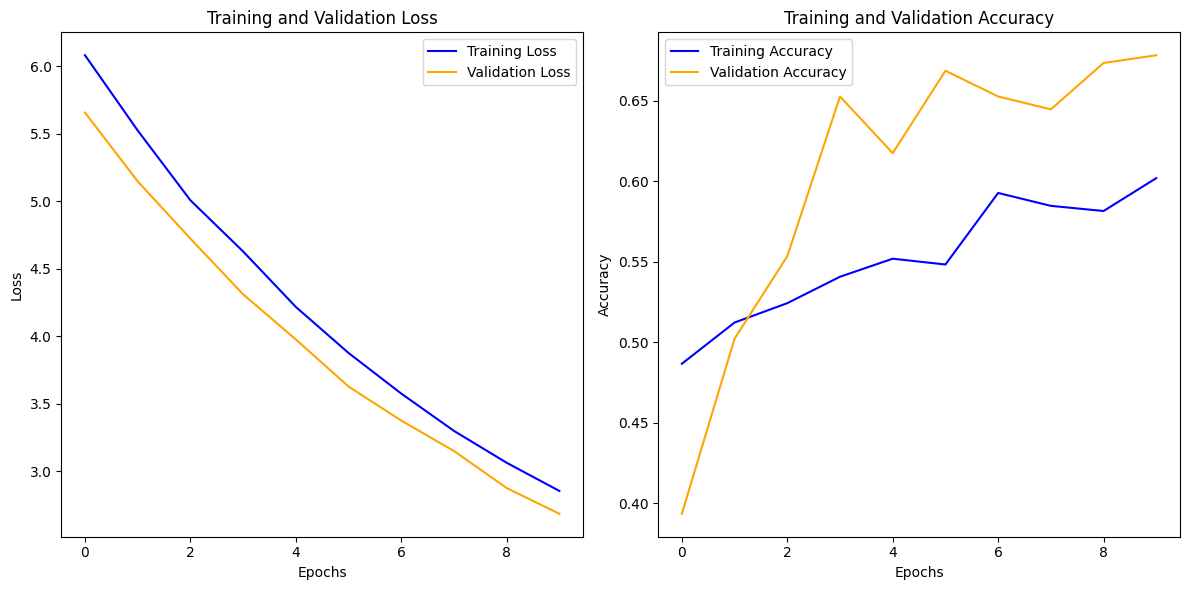

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

test_loss, test_accuracy = model_efficientnet.evaluate([X_test_img, X_test_tab], y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred_prob = model_efficientnet.predict([X_test_img, X_test_tab])


y_pred = (y_pred_prob > 0.5).astype(int)


from sklearn.metrics import classification_report, confusion_matrix


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6768 - loss: 3.1206
Test Loss: 3.1297
Test Accuracy: 0.6656
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step
Confusion Matrix:
[[342 156]
 [ 53  74]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77       498
         1.0       0.32      0.58      0.41       127

    accuracy                           0.67       625
   macro avg       0.59      0.63      0.59       625
weighted avg       0.76      0.67      0.69       625



# Part 2 Image only model Unimodal Approach

In [2]:
# Paths
metadata_path = '/content/drive/MyDrive/Project Data/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx'
image_dir = '/content/drive/MyDrive/Project Data/midasmultimodalimagedatasetforaibasedskincancer'

# Step 1: Load Metadata
metadata = pd.read_excel(metadata_path)
metadata = metadata.dropna(subset=['midas_melanoma'])
metadata = metadata[metadata['midas_file_name'].isin(os.listdir(image_dir))]

# Map binary labels
metadata['midas_melanoma'] = metadata['midas_melanoma'].map({'no': 0, 'yes': 1})
metadata['midas_melanoma'] = metadata['midas_melanoma'].astype(int)




In [3]:
#Image Preprocessing

import cv2
def apply_clahe(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img_gray)

def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    try:
        clahe_img = apply_clahe(img)
        clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
        resized_img = cv2.resize(clahe_img, (128, 128)) / 255.0
        return resized_img
    except Exception:
        return None

image_data, labels = [], []
for _, row in metadata.iterrows():
    image_path = os.path.join(image_dir, row['midas_file_name'])
    img = process_image(image_path)
    if img is not None:
        image_data.append(img)
        labels.append(row['midas_melanoma'])

image_data = np.array(image_data)
labels = np.array(labels)

In [8]:
from albumentations import Compose, CLAHE, RandomRotate90, Flip, GaussianBlur, Normalize, Resize

from albumentations import *


X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42, stratify=labels)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data Augmentation
augmentation_pipeline = Compose([
    CLAHE(clipLimit=2.0, p=0.3),
    Flip(p=0.5),
    RandomRotate90(p=0.5),
    GaussianBlur(blur_limit=3, p=0.3),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    Resize(128, 128)
])


def augment_image(image):
    augmented = augmentation_pipeline(image=image)
    return augmented['image']

X_train_augmented = np.array([augment_image(image) for image in X_train])

<ipython-input-8-ce2236554cf3>:15: UserWarning: Argument 'clipLimit' is not valid and will be ignored.
  CLAHE(clipLimit=2.0, p=0.3),
<ipython-input-8-ce2236554cf3>:16: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  Flip(p=0.5),
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [9]:
#  EfficientNetB0 image model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import multiply


def se_block(input_tensor, ratio=16):
    channel_axis = -1
    channels = input_tensor.shape[channel_axis]
    se_shape = (1, 1, channels)
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return multiply([input_tensor, se])

image_input = Input(shape=(128, 128, 3), name="image_input")
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=image_input)

x = base_model.output
x = se_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
final_output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=image_input, outputs=final_output)

model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

# Train Image-Only Model
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    X_train_augmented, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/8
79/79 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.7457 - loss: 0.5401 - val_accuracy: 0.4480 - val_loss: 1.3464 - learning_rate: 7.5000e-05
Epoch 2/8
79/79 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8231 - loss: 0.4216 - val_accuracy: 0.4960 - val_loss: 1.6120 - learning_rate: 7.5000e-05
Epoch 3/8
79/79 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.8352 - loss: 0.3817 - val_accuracy: 0.2720 - val_loss: 0.8583 - learning_rate: 7.5000e-05
Epoch 4/8
79/79 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8577 - loss: 0.3375 - val_accuracy: 0.2032 - val_loss: 1.0588 - learning_rate: 7.5000e-05
Epoch 5/8
79/79 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8739 - loss: 0.2940 - val_accuracy: 0.2032 - val_loss: 1.2266 - learning_rate: 7.5000e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)






20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 748ms/step - accuracy: 0.4381 - loss: 1.8543
Test Loss: 1.3464
Test Accuracy: 0.4480
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Melanoma", "Melanoma"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix


Classification Report:
              precision    recall  f1-score   support

 No Melanoma       0.80      0.41      0.54       498
    Melanoma       0.21      0.61      0.31       127

    accuracy                           0.45       625
   macro avg       0.51      0.51      0.43       625
weighted avg       0.68      0.45      0.49       625



array([[202, 296],
       [ 49,  78]])